In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import numpy as np


Model: "od_esolver_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1)                 2         
                                                                 
 dense_18 (Dense)            (None, 25)                50        
                                                                 
 dense_19 (Dense)            (None, 50)                1300      
                                                                 
 dense_20 (Dense)            (None, 55)                2805      
                                                                 
 dense_21 (Dense)            (None, 10)                560       
                                                                 
 dense_22 (Dense)            (None, 1)                 11        
                                                                 
Total params: 4,728
Trainable params: 4,728
Non-traina

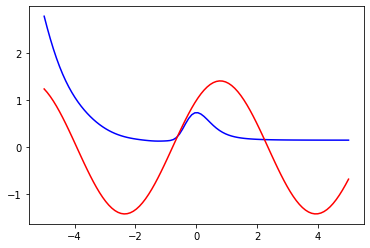

In [6]:
class ODEsolver(Sequential):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.loss_tracker = keras.metrics.Mean(name = 'my_loss')

  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self, data):
    batch_size = tf.shape(data)[0]
    x = tf.random.uniform((batch_size, 1), minval = -5, maxval = 5)

    with tf.GradientTape() as tape:
      with tf.GradientTape() as tape2:
        tape2.watch(x)
        y_pred = self(x, training = True)
      dy = tape2.gradient(y_pred, x)
      
      with tf.GradientTape() as tape3:
        tape3.watch(x)
        dy = self(x, training = True)
      dy_2 = tape3.gradient(dy, x)
      x_o = tf.zeros((batch_size, 1))
      y_o = self(x_o, training = True)
      eq = dy_2 + y_pred
      ic = y_o - 1
      loss = keras.losses.mean_squared_error(0., eq) + keras.losses.mean_squared_error(0., ic)

    grads = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

    self.loss_tracker.update_state(loss)

    return {'my_loss': self.loss_tracker.result()}

model = ODEsolver()

model.add(Dense(1, activation='swish', input_shape=(1,)))
#model.add(Dense(100, activation='tanh'))
#model.add(Dense(300, activation='elu'))
model.add(Dense(25, activation='swish'))
#model.add(Dense(300, activation='tanh'))
model.add(Dense(50, activation='swish'))
#model.add(Dense(250, activation='exponential'))

model.add(Dense(55, activation='swish'))
model.add(Dense(10, activation='swish'))
model.add(Dense(1))

model.summary()

model.compile(optimizer=RMSprop(),metrics=['loss'])
x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=1000, verbose=1)

x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a, color='b', label='Solución real')
plt.plot(x_testv, np.sin(x) + np.cos(x), color='r', label='Solución real')
plt.show()
